#### Char2Mel Generation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../../')
print(sys.path)
import numpy as np
import torch
import pandas as pd
import seaborn as sns; sns.set()
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from models.mlmodeldic import best_model_path_and_settings
from tts.Alternative.neuravoice import CharToMel
from models.mlmodeldic import best_model_path_and_settings
from models.phoneme import Phoneme43
from tts.duration.phoneme_duration import PhonemeDuration
from nlp.kana.kana import text_to_kana
from tools.libaudio.utils import load
from tools.libaudio.display import show_spec, show_mel
from tools.libaudio.feature import melspectrogram

['/var/Sources/experiments/core/tts/Alternative', '/home/kaz/anaconda3/envs/core/lib/python37.zip', '/home/kaz/anaconda3/envs/core/lib/python3.7', '/home/kaz/anaconda3/envs/core/lib/python3.7/lib-dynload', '', '/home/kaz/.local/lib/python3.7/site-packages', '/home/kaz/anaconda3/envs/core/lib/python3.7/site-packages', '/home/kaz/anaconda3/envs/core/lib/python3.7/site-packages/Mako-1.0.7-py3.7.egg', '/home/kaz/anaconda3/envs/core/lib/python3.7/site-packages/IPython/extensions', '/home/kaz/.ipython', '../../']


In [2]:
device = 'cuda:3'

In [67]:
model_name = 'char2mel_512_512_32_ver9'
#model_name = 'char2mel512_512_16_ver9'
#model_name = 'char2mel_256_16_ver9'
#model_name = 'char2mel256_16_ver8'
#model_name = 'char2mel512_512_16_ver8'
#model_name = 'char2mel_16_ver6'
#model_name = 'char2mel_24_ver6'
#model_name = 'char2mel_16_ver6_single5'
#model_name = 'char2mel_1_ver5'
#model_name = 'char2mel_16_ver1'
#model_name = 'char2mel_24_ver1'
#model_name = 'char2mel3'
#model_name = 'char2mel'  # oldest

In [68]:
code = model_name.replace('_single5','')[-1]
version = 1 if code == 'l' or code =='1' else int(code)

Load Char2Mel Model

In [69]:
model_path, settings = best_model_path_and_settings(model_name, 'loss_ave', is_lower_better=True)
model_path, settings

('/diskB/6/out/models/char2mel/char2mel_512_512_32_ver9_epoch100_lr0.001_loss0-375_1',
 {'lr': 0.001,
  'n_epoch': 100,
  'encode_type': 'onehot',
  'hidden_size': 512,
  'K': 10,
  'out_size': 512})

In [70]:
if model_path: model = CharToMel.init_from_settings(settings, model_path, device=device, **{'version':version})
else:          model = CharToMel(encode_type='onehot', K=20, hidden_size=256, out_size=278, device=device, version=version)

model version 9
Trainable Parameters: 5.600 million


In [71]:
print(model)

CharToMel(
  (H1): GRUCell(171, 512)
  (H2): GRUCell(683, 512)
  (H3): GRUCell(683, 512)
  (window): AttentionKGaussianWindow(
    (Wh1p): Linear(in_features=512, out_features=30, bias=True)
  )
  (Wh1y): Linear(in_features=512, out_features=512, bias=True)
  (Wh2y): Linear(in_features=512, out_features=512, bias=True)
  (Wh3y): Linear(in_features=512, out_features=512, bias=True)
  (Y): Linear(in_features=512, out_features=128, bias=True)
  (mse_loss): MSELoss()
)


In [72]:
#for n, p in model.named_parameters():
#    print(n, p.data)

Load Duration Model

In [73]:
duration_model_path, duration_settings = best_model_path_and_settings('phoneme_duration', 'loss_average', is_lower_better=True)
duration_model_path, duration_settings

('/diskB/6/out/models/phoneme_duration/phoneme_duration_hid100_rnnnum1_embeddim20_directbi_batchnormrnnoff_batchnormfullyoff_lr0.01_loss1655.643_acc0.729_index40',
 {'lr': 0.01,
  'epoch': 3,
  'iter': 29000,
  'rnn_type': 2,
  'is_bidirectional': True,
  'n_layers': 1,
  'batchnorm_rnn': False,
  'batchnorm_fully': False,
  'hidden_size': 100,
  'embedding_dim': 20,
  'annealing_rate': 0.9,
  'annealing_interval': 1000,
  'last_lr': 0.000471012869724625})

In [74]:
duration_model = PhonemeDuration.init_from_settings(
    duration_settings,
    duration_model_path,
    device=device,
    **{
        'disable_cuda':False,
        'cuda_device_ids':None,
        'cuda_output_device':None,
        'verbose':False
    })
duration_model.eval()  # without droput
duration_model.cuda()

PhonemeDuration(
  (embeds): Embedding(43, 20)
  (rnns): Sequential(
    (rnn_0): [0] GRU (bidirectional) (
    rnn_input_size=20,
    rnn_hidden_size=100,
    device=None)
    
  )
  (dropout): Dropout(p=0)
  (fully_connected): FullyConnected(
    (fully_connected): DataParallel(
      (module): Linear(in_features=100, out_features=12, bias=False)
    )
  )
)

In [75]:
#for n, p in duration_model.named_parameters():
#    print(n, p.data)

Predict Duration & Genarate Mel Spectrogram

In [87]:
%time
text = 'ケツアツハケンコウノバロメータートシテジュウヨウデアル'
#text = '本当にそうなることが'
#text = 'それです'
#text = 'しました'
#text = '水をマレーシアから買わなくてはならないのです。'
#text = '木曜日、停戦会談は、何の進展もないまま終了しました。'
#text = '上院議員は私がデータをゆがめたと告発した。'
#text = 'むかし、むかし、ひとりの老人が住んでいた。'
#text = 'これとそれは'
#text = '週に四回、フランスの授業があります'
#text = '許可書がなければここへは入れない'
#text = '許可書'
#text = '大声で泣きながら、女の子は母親を探していた'
#text = '無罪の人々は、もちろん放免された。'
#text = '末期試験に備えて、本当に気合いを入れて勉強しなきゃ'
#text = '疲労やら、飢えやらで、彼は目眩を感じた'
#text = 'むしろロン毛のほうが禿げやすいって聞いたぞ'
#text = '容姿端麗、頭脳明晰、運動神経抜群、家は金持ちで、ついでに学生会の副会長をしてたりもする、いわゆる、パーフェクトな奴だ'
#text = '分析においては、クルツによって最初に分析された、権威的行動の類型に負っている部分が大きい。'
#text = 'さよならを言わなければなりません。'
#text = 'センセイガクは科学的な根拠もないのに、とても人気があって、センセイガクは信じている人が多いようです。'
#text = '案の定、あの業者、今日になって泣きついてきたよ。'
#text = 'スマートフォンからフィーチャーフォンまでマルチデバイスに対応'
kana_text = text_to_kana(text)
kana_text

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 15.3 µs


'ケツアツハケンコウノバロメータートシテジュウヨウデアル'

In [88]:
%time
phonemes = Phoneme43.text_to_indices(kana_text)
phoneme_names = Phoneme43.to_phoneme_names(phonemes)
phonemes, phoneme_names, len(phonemes)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 19.6 µs


([25,
  3,
  26,
  2,
  0,
  26,
  2,
  36,
  0,
  25,
  3,
  10,
  25,
  4,
  2,
  33,
  4,
  28,
  0,
  38,
  4,
  32,
  8,
  24,
  5,
  24,
  4,
  35,
  1,
  24,
  3,
  13,
  2,
  2,
  12,
  4,
  2,
  29,
  3,
  0,
  38,
  2],
 ['k',
  'e',
  'ts',
  'u',
  'a',
  'ts',
  'u',
  'h',
  'a',
  'k',
  'e',
  'N',
  'k',
  'o',
  'u',
  'n',
  'o',
  'b',
  'a',
  'r',
  'o',
  'm',
  'eH',
  't',
  'aH',
  't',
  'o',
  'sh',
  'i',
  't',
  'e',
  'j',
  'u',
  'u',
  'y',
  'o',
  'u',
  'd',
  'e',
  'a',
  'r',
  'u'],
 42)

In [89]:
%time
score, durations = duration_model.predict(phonemes)
score, durations

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.78 µs


(array(3519.5332, dtype=float32),
 [70.0,
  70.0,
  70.0,
  30.0,
  70.0,
  70.0,
  30.0,
  70.0,
  30.0,
  70.0,
  70.0,
  70.0,
  70.0,
  70.0,
  30.0,
  70.0,
  30.0,
  70.0,
  30.0,
  70.0,
  30.0,
  70.0,
  200.0,
  200.0,
  200.0,
  70.0,
  30.0,
  70.0,
  30.0,
  30.0,
  70.0,
  70.0,
  30.0,
  30.0,
  70.0,
  70.0,
  30.0,
  30.0,
  30.0,
  70.0,
  70.0,
  200.0])

In [90]:
list(zip(phoneme_names, durations))

[('k', 70.0),
 ('e', 70.0),
 ('ts', 70.0),
 ('u', 30.0),
 ('a', 70.0),
 ('ts', 70.0),
 ('u', 30.0),
 ('h', 70.0),
 ('a', 30.0),
 ('k', 70.0),
 ('e', 70.0),
 ('N', 70.0),
 ('k', 70.0),
 ('o', 70.0),
 ('u', 30.0),
 ('n', 70.0),
 ('o', 30.0),
 ('b', 70.0),
 ('a', 30.0),
 ('r', 70.0),
 ('o', 30.0),
 ('m', 70.0),
 ('eH', 200.0),
 ('t', 200.0),
 ('aH', 200.0),
 ('t', 70.0),
 ('o', 30.0),
 ('sh', 70.0),
 ('i', 30.0),
 ('t', 30.0),
 ('e', 70.0),
 ('j', 70.0),
 ('u', 30.0),
 ('u', 30.0),
 ('y', 70.0),
 ('o', 70.0),
 ('u', 30.0),
 ('d', 30.0),
 ('e', 30.0),
 ('a', 70.0),
 ('r', 70.0),
 ('u', 200.0)]

In [91]:
sum(durations), (sum(duration_model.predict(phonemes)[1])/1000)*24000

(2860.0, 68640.0)

In [92]:
%time
mel_generated, phi, w = model.generate(phonemes, duration_model)
mel_generated, mel_generated.shape, phi, phi.shape, w, w.shape

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.4 µs


(array([[ 5.8988738e-01,  4.5233011e-01,  1.7516184e-01, ...,
          3.2911446e-02, -6.4225672e-03,  7.7297371e-03],
        [ 1.5231267e+00,  8.3284396e-01,  3.3163622e-01, ...,
          5.2338634e-03,  6.1476845e-02,  8.7933056e-04],
        [ 1.8215127e+00,  9.7044605e-01,  3.5888746e-01, ...,
          1.7468939e-02,  4.4468295e-02, -6.3072033e-03],
        ...,
        [-3.9094200e+00, -2.9069889e+00, -1.8237705e+00, ...,
         -9.2075042e-02, -9.4665430e-02, -2.0675024e-02],
        [-3.9231191e+00, -2.9134481e+00, -1.8252516e+00, ...,
         -9.2340283e-02, -9.5164798e-02, -1.9689998e-02],
        [-3.9368162e+00, -2.9198840e+00, -1.8267463e+00, ...,
         -9.2593841e-02, -9.5672511e-02, -1.8692574e-02]], dtype=float32),
 (229, 128),
 array([[3.4878812 , 9.291076  , 3.2446442 , ..., 0.        , 0.        ,
         0.        ],
        [0.01600285, 0.26163274, 0.15125795, ..., 0.        , 0.        ,
         0.        ],
        [0.01055647, 0.0637257 , 0.14264789, 

In [93]:
phi_frame = pd.DataFrame(phi.T, index=phoneme_names).iloc[::-1]  # reverse by row
phi_frame

,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,228
u,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.239108e-42,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.703503e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.025970e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.556811e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.629388e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.921331e-27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
o,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
y,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.270697e-41,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.888858e-31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.117777e-22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 0.98, 'φ(t, u)')

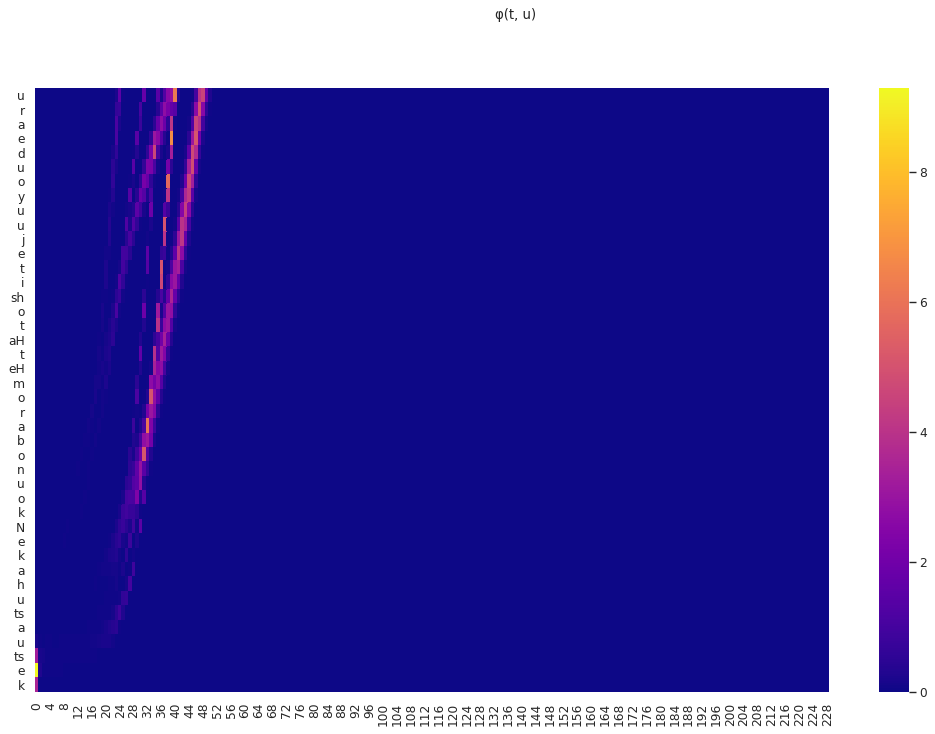

In [94]:
figure(num=None, figsize=(16, 10), dpi=80)
sns.heatmap(phi_frame, cmap="plasma")
plt.suptitle('φ(t, u)')

In [95]:
phoneme43_names = [Phoneme43(i).name for i in range(len(Phoneme43))]
w_frame = pd.DataFrame(w.T, index=phoneme43_names).iloc[::-1]  # reverse by row
w_frame

,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,228
silE,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
silB,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
q,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r,0.000000e+00,0.000000e+00,0.000000e+00,1.050992e-04,0.000000e+00,9.926736e-19,1.739413e-03,8.459228e-06,8.491782e-24,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
h,5.751894e-15,1.509809e-22,9.573204e-08,4.724675e-04,1.104449e-07,3.521602e-03,3.519534e-02,1.333545e-02,2.694699e-02,3.413733e-03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sh,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.485195e-22,0.000000e+00,0.000000e+00,3.890978e-32,3.667285e-09,2.218750e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.015890e-16,1.292226e-02,1.495979e-09,1.642572e-32,1.480261e-32,3.910673e-18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 0.98, 'w(t)')

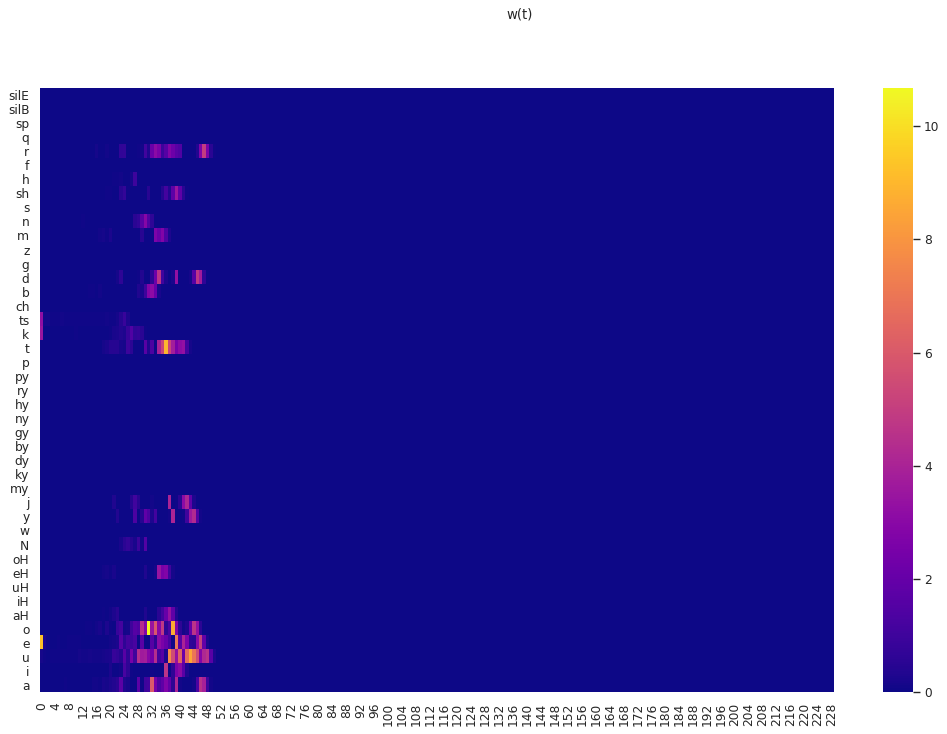

In [96]:
figure(num=None, figsize=(16, 10), dpi=80)
sns.heatmap(w_frame, cmap="plasma")
plt.suptitle('w(t)')

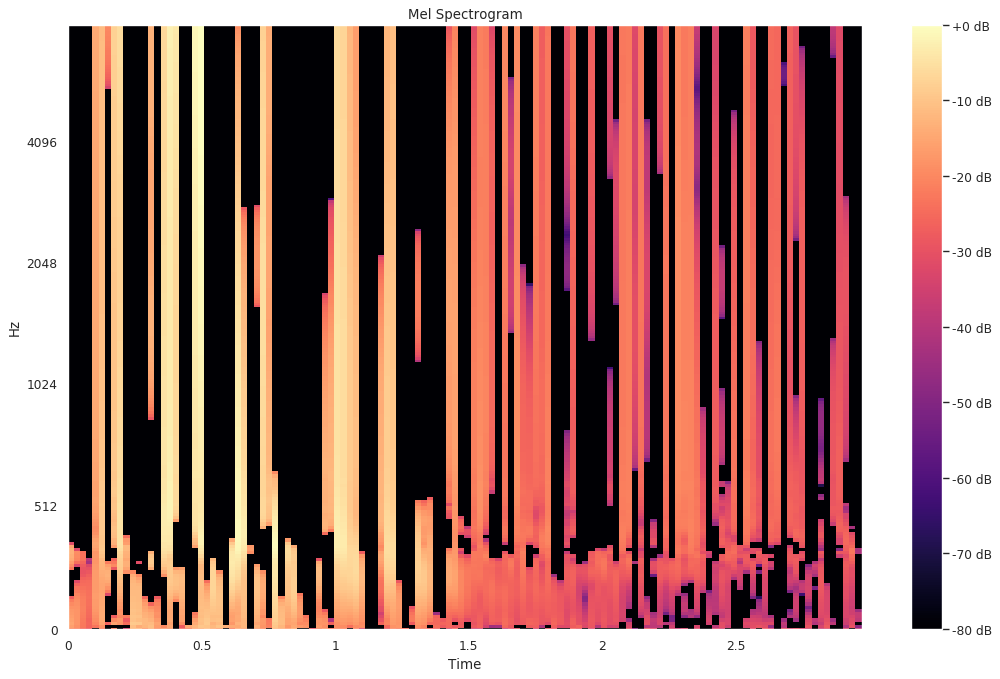

In [97]:
show_mel(mel_generated)

Ground Truth

In [98]:
key = 'BASIC5000_0005'
wav_005 = load(f'/diskB/6/Datasets/VoiceData/jsut_ver1.1/basic5000/wav/{key}.wav', sample_rate=24000)
mel = melspectrogram(wav_005, sample_rate=24000, n_fft=2048, hop_length=300, power=2.0)

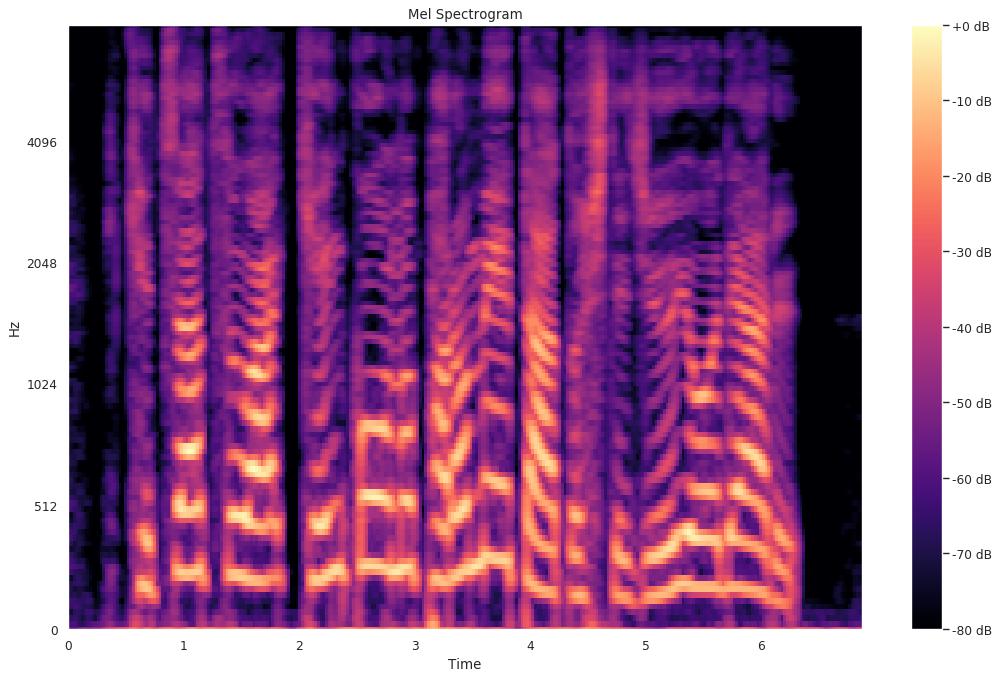

In [24]:
show_mel(mel)